# Main Task

## Libraries

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

## Instantiating SparkSession & Load the Dataset

In [3]:
spark = (SparkSession.builder
         .master("local[*]")
         .appName("Spotify Data Analysis")
         .config("spark.ui.showConsoleProgress", "false")
         .getOrCreate())
spark.sparkContext.setLogLevel("ERROR")

24/04/18 21:46:28 WARN Utils: Your hostname, Yoda-plus resolves to a loopback address: 127.0.1.1; using 192.168.1.152 instead (on interface wlp0s20f3)
24/04/18 21:46:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/18 21:46:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/18 21:46:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
df = spark.read.parquet("data/spotify.parquet")

## Check the Schema

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)




1. **`id`**: The unique identifier for each track on Spotify. This is typically a string of characters that Spotify uses to uniquely identify a song in their system.

2. **`name`**: The name of the track. This is a string that represents the title of the song.

3. **`album`**: The name of the album on which the track appears. This helps in identifying collections of songs released together by an artist.

4. **`album_id`**: Similar to the track ID, this is a unique identifier for the album. Useful for linking tracks to specific albums.

5. **`artists`**: The name of the artist or artists who performed or created the track. This field might contain multiple names if the track has multiple artists.

6. **`artist_ids`**: A unique identifier or identifiers for the artist or artists. Like `artists`, this can include multiple IDs separated by a delimiter if there are multiple artists.

7. **`track_number`**: The track's position on its album. This is a numerical order of where the track appears on its respective album.

8. **`disc_number`**: The number of the disc on which the track appears if the album has multiple discs.

9. **`explicit`**: A boolean value indicating whether the track has explicit content. True means there is explicit content; false means there isn't.

10. **`danceability`**: A measure from 0.0 to 1.0 representing how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

11. **`energy`**: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

12. **`key`**: The key the track is in. Integers map to pitches using standard Pitch Class notation.

13. **`loudness`**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

14. **`mode`**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

15. **`speechiness`**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value.

16. **`acousticness`**: A measure from 0.0 to 1.0 of how acoustic a track is. A score of 1.0 means the track is most likely an acoustic one.

17. **`instrumentalness`**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

18. **`liveness`**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

19. **`valence`**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric).

20. **`tempo`**: The overall estimated tempo of a track in beats per minute (BPM).

21. **`duration_ms`**: The duration of the track in milliseconds.

22. **`time_signature`**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

23. **`year`**: The year in which the track was released.

24. **`release_date`**: T of insights can be extracted from each attribute.he exact date on which the track was released.

In [6]:
df.show(1)

+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|Testify|The Battle Of Los...|2eia0myWFgoHuttJy...|['Rage Against Th...|['2d0hyoQ5

## Preprocess the Data

In [7]:
final_df = (df
            .select("name", 
                    "release_date", "year",
                    "album", 
                    "artists", 
                    "track_number", 
                    'disc_number', 
                    'explicit', 
                    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                    'duration_ms'
                    )
            .withColumn("release_date", F.to_date("release_date", 
                                                  "yyyy-MM-dd"))
            .withColumn("release_date", F.when(F.isnull("release_date"),
                                               F.to_date(F.concat(F.format_string("%04d", "year"), F.lit("-07-01")), 
                                                         "yyyy-MM-dd")).otherwise(F.col("release_date")))
            .withColumn("artists", F.split(F.regexp_replace("artists", r"[\[\]']", ""), ","))
            .withColumn("duration_s", F.col("duration_ms") / 1000)
            .withColumn("minute", (F.col("duration_s") / 60).cast("int"))
            .withColumn("second", (F.col("duration_s") % 60).cast("int"))
            .withColumn("duration", F.concat(F.format_string("%02d", "minute"), F.lit(":"), F.format_string("%02d", "second")))
            .withColumn("decade", F.concat((F.floor(F.col("year") / 10) * 10).cast("string"), F.lit("s")))
            .where(F.col('year') > 1900))

In [8]:
final_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- year: long (nullable = true)
 |-- album: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- duration_s: double (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)
 |-- duration: string (nullable = false)
 |-- decade: string (nullable = true)


In [9]:
n_null_dates = final_df.where(F.col("release_date").isNull()).count()
n_null_dates

0

In [10]:
n_deleted = df.count() - final_df.count()
n_deleted

24

In [11]:
del n_deleted, n_null_dates

In [12]:
final_df.show(5)

+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+----------+------+------+--------+------+
|                name|release_date|year|               album|             artists|track_number|disc_number|explicit|danceability|energy|          loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|duration_s|minute|second|duration|decade|
+--------------------+------------+----+--------------------+--------------------+------------+-----------+--------+------------+------+------------------+-----------+------------+----------------+--------+-------+-------+-----------+----------+------+------+--------+------+
|             Testify|  1999-11-02|1999|The Battle Of Los...|[Rage Against The...|           1|          1|   false|        0.47| 0.978|            -5.399|     0.0727|     

## Data Aggregation, filtering and Transformation

#### Annual and Decennial Release Monitor

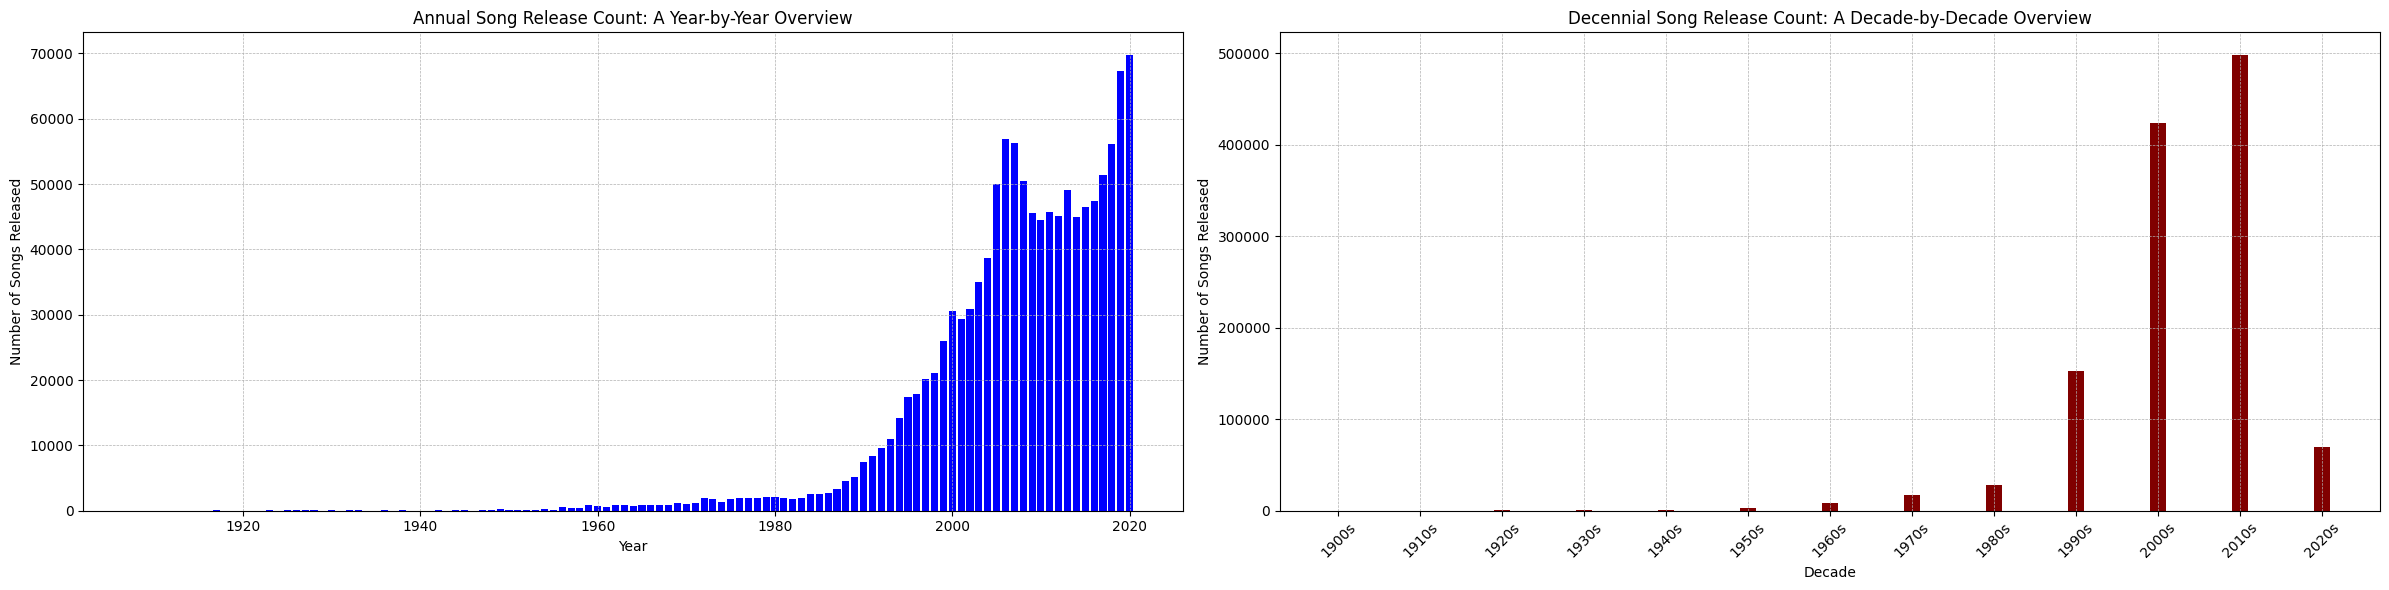

In [13]:
annual_data = (final_df
               .groupby("year")
               .agg(F.count("name").alias('number_of_songs'))
               .orderBy("year")).toPandas()
decennial_data = (final_df
               .groupby("decade")
               .agg(F.count("name").alias('number_of_songs'))
               .orderBy("decade")).toPandas()

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.bar(annual_data['year'], annual_data['number_of_songs'], color='blue')
plt.title("Annual Song Release Count: A Year-by-Year Overview")
plt.xlabel("Year")
plt.ylabel("Number of Songs Released")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.bar(decennial_data['decade'], decennial_data['number_of_songs'], color='maroon', width=0.2)
plt.title("Decennial Song Release Count: A Decade-by-Decade Overview")
plt.xlabel("Decade")
plt.ylabel("Number of Songs Released")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
del annual_data, decennial_data

#### Average Features by Decade (danceability, energy, tempo):

In [14]:
decennial_data = (final_df
                  .groupBy("decade")
                  .agg(F.avg("danceability").alias("avg_danceability"),
                       F.avg("energy").alias("avg_energy"),
                       F.avg("valence").alias("avg_valence"))
                  .orderBy("decade")).toPandas()
decennial_data

,decade,avg_danceability,avg_energy,avg_valence
0,1900s,0.611750,0.480005,0.751818
1,1910s,0.506942,0.253687,0.480892
2,1920s,0.612497,0.267636,0.627998
3,1930s,0.572007,0.324696,0.572411
4,1940s,0.419087,0.242732,0.401912
5,1950s,0.426566,0.297097,0.424613
6,1960s,0.433258,0.350447,0.456219
7,1970s,0.481377,0.453878,0.512866
8,1980s,0.480646,0.466168,0.477159
9,1990s,0.463538,0.408865,0.426817


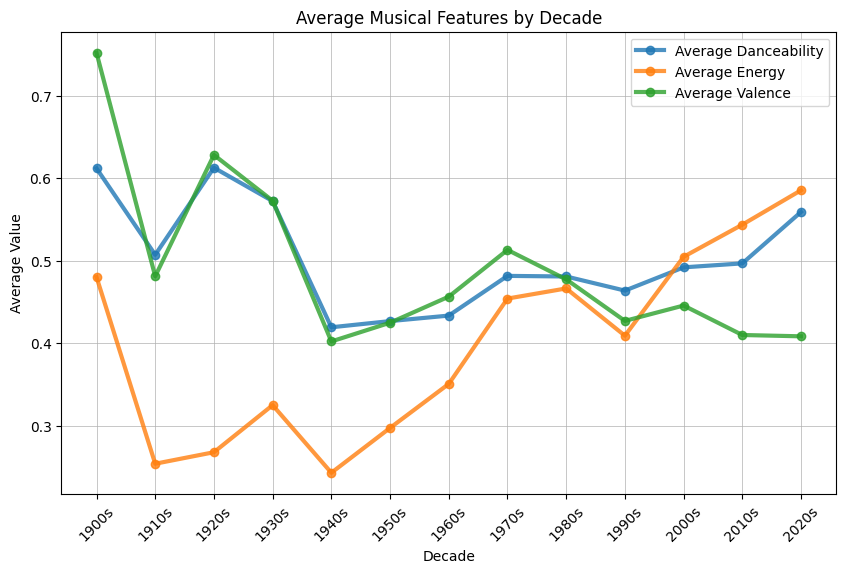

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(decennial_data['decade'], decennial_data['avg_danceability'], label='Average Danceability', marker='o', linewidth=3, alpha=0.8)
plt.plot(decennial_data['decade'], decennial_data['avg_energy'], label='Average Energy', marker='o', linewidth=3, alpha=0.8)
plt.plot(decennial_data['decade'], decennial_data['avg_valence'], label='Average Valence', marker='o', linewidth=3, alpha=0.8)
plt.title('Average Musical Features by Decade')
plt.xlabel('Decade')
plt.xticks(rotation=45)
plt.ylabel('Average Value')
plt.legend()
plt.grid(linewidth=0.5)
plt.show()
del decennial_data

#### Average Duration

In [16]:
(final_df
 .agg(F.avg("minute").cast("int").alias("min"), 
      F.avg("second").cast("int").alias("sec"))
 .select(F.concat(F.format_string("%02d", "min"), F.lit(":"), F.format_string("%02d", "sec")).alias("average_duration"))
 .show())

+----------------+
|average_duration|
+----------------+
|           03:29|
+----------------+


## Investigating Top-K Records

In [17]:
k = 10

### Top-k Tracks by Danceability

In [18]:
(final_df
 .select("name", "danceability")
 .orderBy(F.desc("danceability"))
 .limit(10)
 .show(truncate=False))

+------------------------------------+------------+
|name                                |danceability|
+------------------------------------+------------+
|Unendlich                           |1.0         |
|Na-try Mo Na Ba Ako                 |0.994       |
|Roll Like Dis / Cha-cha Slide Part 2|0.993       |
|Techno Is Not Fault                 |0.992       |
|Aussie, Aussie (O, Sige!)           |0.991       |
|Le casse-tête (Cannelle, Pruneau)   |0.991       |
|New Life                            |0.99        |
|Esther's Vice                       |0.99        |
|Go Nuts                             |0.988       |
|Believe In Love                     |0.988       |
+------------------------------------+------------+


#### Top-k Artists with the Highest Number of Tracks:

In [19]:
(final_df
 .select(F.explode("artists").alias("artist"))
 .groupby("artist")
 .count()
 .orderBy(F.desc("count"))
 .limit(k)
 .show(truncate=False))

+------------------------+-----+
|artist                  |count|
+------------------------+-----+
|Johann Sebastian Bach   |9473 |
|Ludwig van Beethoven    |5710 |
|Wolfgang Amadeus Mozart |3768 |
|George Frideric Handel  |3008 |
|Antonio Vivaldi         |2851 |
| Neeme Järvi            |2631 |
|Franz Joseph Haydn      |2239 |
|Sergei Prokofiev        |2092 |
|Pyotr Ilyich Tchaikovsky|2036 |
|Johannes Brahms         |2035 |
+------------------------+-----+


### Top-k Artists with the Highest/Lowest Average Valence

In [20]:
(final_df
 .select('valence', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("valence").alias("avg_valence"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy(F.desc("avg_valence"))
 .limit(k)
 .show())

+-----------------+------------------+-------------------+
|           artist|       avg_valence|duration in seconds|
+-----------------+------------------+-------------------+
|     Gerry Wimsey|               1.0|              103.4|
|  mike mcgoldrick|             0.994|            192.053|
|    dezi donnelly|             0.994|            192.053|
|     Fred Whiting|             0.994|            143.933|
|    Niall Vallely|             0.994|            192.053|
| Tsvyatko Blagoev|             0.993|             166.96|
|Bridge Céilí Band|             0.993|              205.2|
|The Hyde Brothers|             0.991|            177.493|
|    Harry Bradley|0.9908666666666667| 176.48673333333332|
| Joseph Mussulman|              0.99|             97.227|
+-----------------+------------------+-------------------+


In [21]:
(final_df
 .select('valence', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("valence").alias("avg_valence"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy("avg_valence")
 .limit(k)
 .show())

+--------------------+-----------+-------------------+
|              artist|avg_valence|duration in seconds|
+--------------------+-----------+-------------------+
|       Nanyana/Bruce|        0.0|              11.16|
| applause for Leo...|        0.0|             16.467|
|        Ben Gwilliam|        0.0|             172.04|
|          Shortstuff|        0.0|            290.942|
|Senator Daniel In...|        0.0|              16.84|
|      Kiminori Chiba|        0.0|             14.141|
|        Edwin Grasse|        0.0|             115.04|
|       Jordan Wilson|        0.0|             6.8665|
|      Jonathan Byers|        0.0|                4.0|
|       Richard Adler|        0.0|             12.093|
+--------------------+-----------+-------------------+


### Top-k Artists with the Highest/Lowest Average Danceability

In [22]:
(final_df
 .select('danceability', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("danceability").alias("avg_danceability"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy(F.desc("avg_danceability"))
 .limit(k)
 .show())

+------------------+----------------+-------------------+
|            artist|avg_danceability|duration in seconds|
+------------------+----------------+-------------------+
|  Andrea HEinstein|           0.992|            337.058|
|           Juelz B|           0.987|            198.347|
|               Gen|           0.987|            170.713|
|Audio Soul Project|           0.986|            218.227|
|       LILDRUGHILL|           0.984|              187.5|
|              Liêm|           0.983|            426.945|
|          3rd Face|           0.981|            412.138|
|        Money Maru|           0.981|            250.333|
|      Franko Murry|            0.98|            219.816|
|       Lul Florida|            0.98|            247.798|
+------------------+----------------+-------------------+


In [23]:
(final_df
 .select('danceability', F.explode("artists").alias("artist"), 'duration_s')
 .groupBy("artist")
 .agg(F.avg("danceability").alias("avg_danceability"), F.avg("duration_s").alias("duration in seconds"))
 .orderBy("avg_danceability")
 .limit(k)
 .show())

+--------------------+----------------+-------------------+
|              artist|avg_danceability|duration in seconds|
+--------------------+----------------+-------------------+
|            Negassie|             0.0|             65.006|
|       Jordan Wilson|             0.0|             6.8665|
|     Chris Petrovski|             0.0|              6.761|
|Estacion Identifi...|             0.0|             12.013|
|        Ben Gwilliam|             0.0|             172.04|
|    Germán Lizarraga|             0.0|             12.267|
|       Brooke Butler|             0.0|              7.495|
|          Blade King|             0.0|            12.4865|
|              D Dawg|             0.0|              6.811|
|        Amiri Baraka|             0.0|             14.893|
+--------------------+----------------+-------------------+


### Top-K Energetic Tracks

In [24]:
(final_df
.select('name', 'energy', 'duration')
.orderBy(F.desc("energy"))
.limit(k)
.show(truncate=False))

+---------------------------+------+--------+
|name                       |energy|duration|
+---------------------------+------+--------+
|Untitled 3                 |1.0   |03:49   |
|Space Odyssee              |1.0   |01:15   |
|Lion & Oil                 |1.0   |02:13   |
|Did You Cum?               |1.0   |01:17   |
|Skald Au Satans Sol        |1.0   |04:28   |
|Soft Water Rhinoceros      |1.0   |08:58   |
|Slottet I Det Fjerne       |1.0   |04:45   |
|I En Hall Med Flesk Og Mjod|1.0   |05:12   |
|Nightvision - v2.0         |1.0   |04:15   |
|Say No To Emo              |1.0   |04:35   |
+---------------------------+------+--------+


### Top-k Recent Tracks

In [25]:
(final_df
 .select("name", "release_date")
 .orderBy(F.desc("release_date"))
 .limit(k)
 .show(truncate=False))

+------------------------+------------+
|name                    |release_date|
+------------------------+------------+
|Red Cup                 |2020-12-18  |
|Red Cup - Radio Edit    |2020-12-18  |
|Red Cup - DJ Roody Remix|2020-12-18  |
|Red Cup - BTNZ Remix    |2020-12-18  |
|To the Beach            |2020-12-11  |
|Coma                    |2020-12-11  |
|Journey                 |2020-12-11  |
|Love                    |2020-12-11  |
|Away from You           |2020-12-11  |
|Absolutego              |2020-12-11  |
+------------------------+------------+


### Top-k Longest Tracks

In [26]:
(final_df
 .select("name", 
         F.col("duration").alias("duration_s"),
         F.col("minute"),
         F.col("second"),
         F.concat(F.format_string("%02d", "minute"), F.lit(":"), F.format_string("%02d", "second")).alias("duration"))
 .orderBy(F.desc("duration_s"))
 .limit(k)
 .show(truncate=False))

+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|name                                                                                                                                   |duration_s|minute|second|duration|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+------+------+--------+
|Gothic Lolita                                                                                                                          |96:04     |96    |4     |96:04   |
|Bargrooves Deluxe Edition 2017 - Continuous Mix 2                                                                                      |95:13     |95    |13    |95:13   |
|Bargrooves Deluxe Edition 2018 Mix 1 - Continuous Mix                                                                                  |94:

### Top-k Most Frequent Artists in Their Active Years

In [27]:
(final_df
 .select(F.explode("artists").alias("artist"), "year")
 .groupBy("artist")
 .agg((F.count("artist") / (F.max("year") - F.min("year"))).alias("track_frequency"))
 .orderBy(F.desc("track_frequency"))
 .limit(k)
 .show(truncate=False))

+------------------------------------+---------------+
|artist                              |track_frequency|
+------------------------------------+---------------+
| Arthur Rubinstein                  |627.0          |
|Sing n Play                         |411.0          |
|TKKG                                |295.0          |
|Adventure Time                      |227.0          |
|Cavedoll                            |200.0          |
| Reginald Goodall                   |200.0          |
| Edith Haller                       |191.0          |
| Christa Mayer                      |187.0          |
| Giuseppe Bruno                     |185.0          |
| Amsterdam Baroque Orchestra & Choir|181.5          |
+------------------------------------+---------------+


### Top-k Albums by the Number of Tracks

In [28]:
(final_df
 .groupBy("album")
 .count()
 .orderBy(F.desc("count"))
 .limit(k)
 .show(truncate=False))

+--------------------------+-----+
|album                     |count|
+--------------------------+-----+
|Greatest Hits             |1800 |
|Live                      |872  |
|The Collection            |343  |
|Love Songs                |337  |
|Super Hits                |330  |
|Platinum & Gold Collection|300  |
|The Best Of               |280  |
|RCA 100 Años de Música    |280  |
|II                        |278  |
|Handel: Messiah           |268  |
+--------------------------+-----+


### Top-k Albums by the Frequency of Tracks With More Than Danceability Threshold

In [29]:
avg_danceability = final_df.agg(F.avg("danceability")).collect()[0][0]
power = 20
threshold = (avg_danceability + 1 * power) / (power + 1)
(final_df
 .groupBy("album")
 .agg((F.sum(F.when(F.col('danceability') > threshold, 1).otherwise(0)) / F.count('album')).alias("frequency"))
 .where(F.col('frequency') > 0)
 .orderBy(F.desc("frequency"))
 .limit(k)
 .show())
del avg_danceability, threshold, power

+--------------------+------------------+
|               album|         frequency|
+--------------------+------------------+
|            Stick Up|               1.0|
|          Full Power|               1.0|
|  Dancing in My Room|               1.0|
|Blurred Lines Parody|               1.0|
|        Look At That|               1.0|
|             Patapon|               1.0|
| Techno Is Not Fault|               1.0|
|     Window Shopping|0.6666666666666666|
|         Speicher 42|               0.5|
|      Twin City Rapp|               0.5|
+--------------------+------------------+


In [30]:
# spark.stop()

## Questions

### 1. Read about how Spark and Hadoop work. What does the term ‘lazy evaluation’ mean for them? Explain with a simple example.

Both Apache Spark and Apache Hadoop are prominent frameworks used for big data processing, but they handle operations quite differently. One key concept in Spark that differentiates it from Hadoop, especially Hadoop's MapReduce component, is **"lazy evaluation."**

Lazy evaluation is a programming concept where the evaluation of an expression is delayed until its value is actually needed. It avoids repeated evaluations and can lead to efficiency improvements by eliminating unnecessary calculations. Apache Spark uses lazy evaluation primarily in its handling of transformations on RDDs (Resilient Distributed Datasets). In Spark, when you define transformations on RDDs—like map, filter, or groupBy—Spark does not execute these transformations immediately. Instead, it creates a plan of what needs to be done, in the form of **a Directed Acyclic Graph (DAG) of steps**. The actual computation on data occurs only when an action (like collect, count, reduce) is called. This approach allows Spark to optimize the entire data processing pipeline, consolidating operations, and thus making the process faster and more resource-efficient.

In other words, lazy evaluation is postponing the execution of the operation by saving the steps in a traversable format, so it could process each one when the data have to be retrieved.

Consider this simple example for further clarification:

1. Data Input: Suppose you have an RDD created from a list of numbers: 1, 2, 3, 4, 5.
2. Transformation 1: You apply a map transformation to multiply each number by 2. In a non-lazy framework, this operation would immediately double each number. However, in Spark, this transformation is just recorded, and no computation happens at this stage. 
3. Transformation 2: Next, you decide to filter out numbers greater than 5. Again, Spark only updates the execution plan to include this filter, but no actual filtering occurs yet.
4. Action: Finally, you ask for the output with an action, such as collect. Only now does Spark compute the results of both the map and filter transformations. It will effectively combine these operations where possible (known as pipelining), do the calculation in one go, and return the result [6, 8, 10].

### 2. Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.

The Hadoop has a columnar storage file format that is called Parquet. Using Parquet files, data can be stored **in columns** instead of rows, which improves <u>compression</u> and <u>encoding</u> techniques when compared to row- or CSV-like formats, which there isn't any optimization embedded in the stored data.

### 3. As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.

We need to specify a directory where Spark will save the checkpointed data. It can be set by using this code:

```python
sc = SparkContext("local", "CheckpointApp")
sc.setCheckpointDir("{path to the directory}")
```

### 4. Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?

We can apply approaches like these:

1. **using optimized file formats**(using columnar storage formats like Parquet or ORC)
2. **database partitioning**(Partitioning is the process of dividing a database or its elements into distinct independent parts)
3. **indexing**(Creating indexes on columns that are frequently used in filter conditions for quickly locating the data without scanning every row of the table)

### 5. Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.

About data size, Pandas can perform very well on data with size up to few gigabytes and performance can decrease quickly when data size is larger than that, on the other hand PySpark is designed for working with big data. in the matter of processing complexity, **Pandas**, rich with its tools, is perfect for detailed and complex transformations and analyses on data that does not require distributed computing while **PySpark**, better suited for processing tasks that need to be scaled across many nodes, its true strength lies in its ability to distribute these tasks effectively across a cluster. Pandas is known for its user-friendly interface. It integrates perfectly with other Python libraries, enhancing its usability; however, for those working in big data environments, PySpark offers powerful capabilities that are essential at scale.
